## Load a Model

In [2]:
!huggingface-cli whoami

⚠️  Warning: 'huggingface-cli whoami' is deprecated. Use 'hf auth whoami' instead.
user:  JaMussCraft


In [3]:
import os
from mmassist.model import build_from_checkpoint
from mmassist.configs.arguments import EvalArguments
from mmassist.eval.eval_utils import parse_inference_setups

ckpt = "/projects/beto/swong2/proassist_data/models/ProAssist-Model-L4096-I10"
inference_setups = "wtag/dialog-klg_val_L0_I1|stream|4k|0.5|summarize_and_drop"
eval_args = EvalArguments(model_path=ckpt, inference_setups=inference_setups)
args_dict = eval_args.to_dict()

model, tokenizer = build_from_checkpoint(ckpt)
model.config.exceed_context_handling = "summarize_and_drop"

model.device

/u/swong2/.conda/envs/proassist/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the base LLM from meta-llama/Meta-Llama-3.1-8B-Instruct


Loading checkpoint shards: 100%|██████████| 4/4 [00:33<00:00,  8.42s/it]


Loading and merging adapter 0 from /projects/beto/swong2/proassist_data/models/ProAssist-Model-L4096-I10


device(type='cuda', index=0)

In [4]:
model.config.exceed_context_handling = "summarize_and_drop"
print(model.config.use_binary_decision_head)


False


### Build the Evaluation Dataset

In [5]:
from mmassist.data import build_train_dataset, build_eval_datasets
from mmassist.configs.arguments import DATA_ROOT_DIR

eval_on_training_data = False

config = model.config
config.data_root_dir = f"{DATA_ROOT_DIR}/processed_data"
config.training_args["data_root_dir"] = f"{DATA_ROOT_DIR}/processed_data"


train_datasets = config.training_args["train_datasets"].replace("dialog_klg_sum", "dialog-klg-sum")
eval_datasets = config.training_args["eval_datasets"].replace("dialog_klg_sum", "dialog-klg-sum")
# eval_datasets = "sthsthv2/narration_val_L4096_I10," + eval_datasets

# eval_datasets = "ego4d/dialog_val_L0_I10"
eval_datasets = inference_setups.split("|")[0]
print(config.training_args["eval_datasets"])

config.training_args["train_datasets"] = train_datasets
config.training_args["eval_datasets"] = eval_datasets

# the original model arguments
all_args_dict = config.to_dict()
all_args_dict.update(config.training_args)

if not eval_on_training_data:
    dataset_dict = build_eval_datasets(**all_args_dict, print_info=True, keep_images=True)
    datasets = list(dataset_dict.values())
else:
    datasets = build_train_dataset(**all_args_dict, print_info=True, keep_images=True)
    datasets = datasets.datasets

sthsthv2/narration_val_L4096_I10,ego4d/dialog-klg-sum_val_L4096_I10,holoassist/dialog-klg-sum_val_L4096_I10,ego4d/narration_val_L4096_I10,ego4d/summary_val_L4096_I10
Evaluation datasets:
* wtag/dialog-klg_val | num samples: 21



In [7]:
dataset = datasets[0]

for sample in dataset:
    print(sample['start_frame_idx'])

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [10]:
dataset[3]

{'dataset': 'wtag/dialog-klg_val_L0_I1',
 'sample_idx': 3,
 'video_uid': 'T54',
 'conversation': [{'role': 'system',
   'content': "You are a proactive assistant. Predict the user's needs and provide assistance before being requested.",
   'start': None,
   'end': None,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'frames',
   'content': None,
   'start': 0,
   'end': 13,
   'time': None,
   'labels': None,
   'progress': None},
  {'role': 'user',
   'content': 'I want to make pour-over coffee.',
   'start': None,
   'end': None,
   'time': 6.6,
   'labels': '',
   'progress': None},
  {'role': 'system',
   'content': 'Task knowledge: Pour-over Coffee\n\nIngredients\n12 oz water\n25 grams whole coffee beans\n\nTools and Utensils\n2-cup liquid measuring cup electric kettle\nkitchen scale\ncoffee grinder\nfilter cone dripper (stainless steel)\npaper basket filter (standard 8-12 cup size) 12-ounce coffee mug\nthermometer\ntimer (optional)\n\nSteps\n1. Measure 12 ou

=== Sample 1 ===
Video ID: T48
Number of images: 1548

=== Conversation ===
1. [SYSTEM]: You are a supportive assistant. Always be ready to help and offer useful advice without being asked.
2. [FRAMES]: 0 - 8
3. [USER]: I want to make pour-over coffee.
4. [SYSTEM]: Task knowledge: Pour-over Coffee

Ingredients
12 oz water
25 grams whole coffee beans

Tools and Utensils
2-cup liquid measuring cup electric kettle
kitchen scale
coffee grinder
filter cone dripper (stainless steel)
paper basket filter (standard 8-12 cup size) 12-ounce coffee mug
thermometer
timer (optional)

Steps
1. Measure 12 ounces of cold water and transfer to a kettle.
2. While the water is boiling, assemble the filter cone. Place the dripper on top of a coffee mug.
3. Prepare the filter insert by folding the paper filter in half to create a semi-circle, and in half again
to create a quarter-circle. Place the paper filter in the dripper and spread open to create a cone.
4. Weigh the coffee beans and grind until the cof

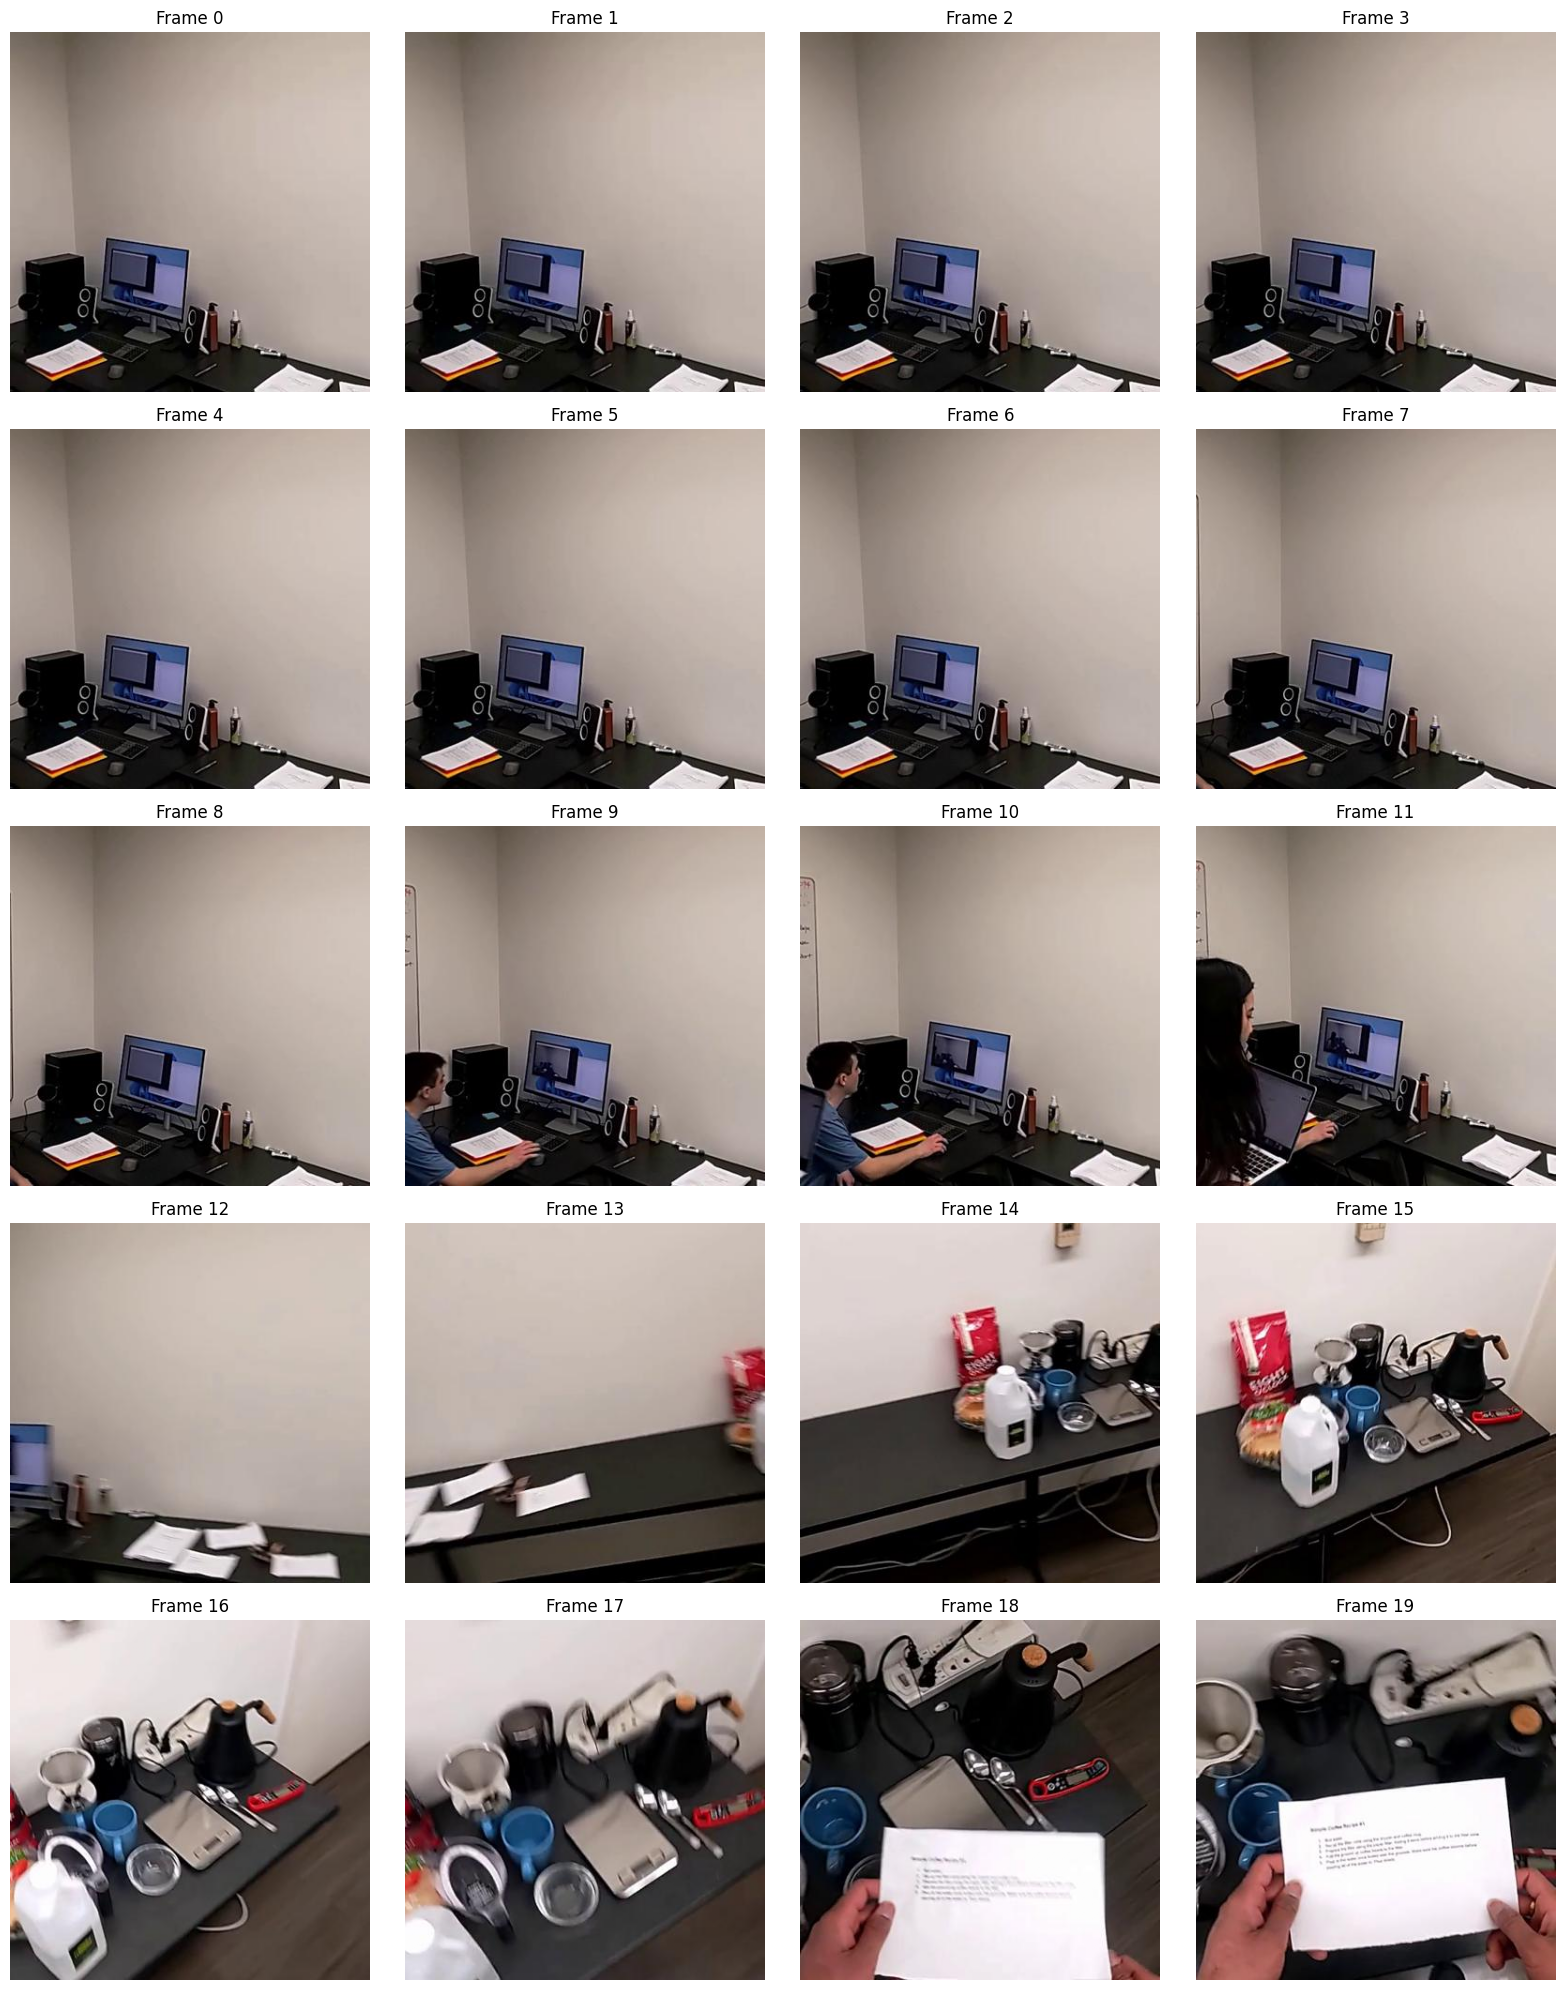


=== Metadata ===
dataset: wtag/dialog-klg_val_L0_I1
sample_idx: 1
video_uid: T48
conversation: <class 'list'> (length: 368)
start_frame_idx: 0
end_frame_idx: 1548
neg_frame_sampling_rate: 0.1


In [27]:
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import numpy as np

def display_sample_with_frames(dataset, sample_idx=0):
    """Display a sample from the dataset with its frames and conversation."""
    
    sample = dataset[sample_idx]
    
    print(f"=== Sample {sample_idx} ===")
    print(f"Video ID: {sample.get('video_uid', 'N/A')}")
    print(f"Number of images: {len(sample.get('images', []))}")
    
    # Display conversation
    if 'conversation' in sample:
        print("\n=== Conversation ===")
        for i, conv in enumerate(sample['conversation']):
            role = conv.get('role', 'unknown')

            if role == "frames":
                content = f"{conv['start']} - {conv['end']}"

            else:
                content = conv.get('content', '')

            print(f"{i+1}. [{role.upper()}]: {content}")
    
    # Display frames
    images = sample.get('images', [])

    img_num_to_display = 20

    print(f"\n=== Displaying {min(img_num_to_display, len(images))} frames ===")
    
    # Create subplot grid
    n_display = min(img_num_to_display, len(images))
    cols = 4
    rows = (n_display + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_display):
        row, col = i // cols, i % cols
        ax = axes[row, col]
        
        # Convert image to displayable format
        img = images[i]

        img_norm = (img - img.min()) / (img.max() - img.min())
        img_np = img_norm.permute(1, 2, 0).detach().cpu().numpy()
        
        ax.imshow(img_np)
        ax.set_title(f'Frame {i}')
        ax.axis('off')
    
    # Hide empty subplots
    for i in range(n_display, rows * cols):
        row, col = i // cols, i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Display additional metadata
    print(f"\n=== Metadata ===")
    for key, value in sample.items():
        if key not in ['images', 'conversations']:
            if isinstance(value, (list, dict)):
                print(f"{key}: {type(value)} (length: {len(value) if hasattr(value, '__len__') else 'N/A'})")
            else:
                print(f"{key}: {value}")

# Display the first sample
display_sample_with_frames(datasets[0], sample_idx=1)

## Build the Streaming Inference Runner

In [15]:
from mmassist.eval.runners.stream_inference import StreamInferenceRunner, FrameOutput

dataset = datasets[0]
not_talk_threshold = 0.3
runner = StreamInferenceRunner.build(
    model=model,
    tokenizer=tokenizer,
    fps=2,
    eval_max_seq_len=4096,
    not_talk_threshold=not_talk_threshold,
    eval_name="demo",
)

### Run streaming inference on a single video

In [17]:
for i in [3]:
    video = dataset[i]
    streams = runner.processor.processed_conv_data_to_stream(video)
    outputs = runner.run_inference_on_video(
        video,
        streams=streams,
        use_gt_context=False,
        verbose=True,
        video_output_dir="video", # the output will be saved to `video/3.mp4`
        max_time=60, # restrict the inference time to 60s; remove to run until the end of the video, and see how IPS work for context management
    )

!!! Set vision encoder in the model, only recommended for on in-the-wild inference. Please dont call this for efficient training & evaluation. Instead, do visual feature pre-extraction.
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


[0.5s] SYSTEM: You are a proactive assistant. Predict the user's needs and provide assistance before being requested.
[0.5s] REF : 
[0.5s] GEN : 
Context Length: 34
[7.0s] USER: I want to make pour-over coffee.
[7.0s] SYSTEM: Task knowledge: Pour-over Coffee

Ingredients
12 oz water
25 grams whole coffee beans

Tools and Utensils
2-cup liquid measuring cup electric kettle
kitchen scale
coffee grinder
filter cone dripper (stainless steel)
paper basket filter (standard 8-12 cup size) 12-ounce coffee mug
thermometer
timer (optional)

Steps
1. Measure 12 ounces of cold water and transfer to a kettle.
2. While the water is boiling, assemble the filter cone. Place the dripper on top of a coffee mug.
3. Prepare the filter insert by folding the paper filter in half to create a semi-circle, and in half again
to create a quarter-circle. Place the paper filter in the dripper and spread open to create a cone.
4. Weigh the coffee beans and grind until the coffee grounds are the consistency of coars

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
